<Axes: >

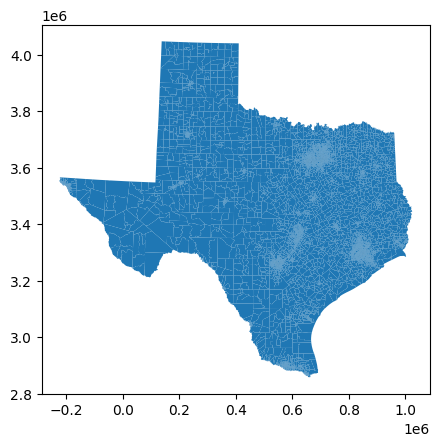

In [2]:
import geopandas as gpd

# load in a shp into a geodataframe, then plot it
load_precincts = gpd.read_file("data/TX_precincts_24/TX_precincts24_with_pop.shp")
load_precincts.plot()

<Axes: >

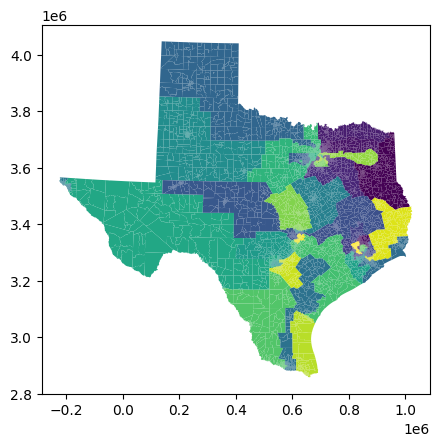

In [3]:
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally

tx_graph = Graph.from_json("data/TX_precincts_24/TX_precincts24_with_pop_and_elections.json")
tx_partition = Partition(tx_graph, assignment="CD25", 
                         updaters={"population": Tally("TOTPOP20", alias="population"), "VAP": Tally("VAP20", alias="VAP20")})
tx_partition.plot(geometries=load_precincts)

In [ ]:
from gerrychain.tree import recursive_tree_part

partition_len = len(tx_partition)
ideal_population = sum(tx_partition["VAP"].values()) / partition_len
initial_partition = recursive_tree_part(tx_graph, range(1, partition_len + 1), pop_target=ideal_population, pop_col="VAP20", epsilon=0.05)

In [ ]:
from gerrychain import MarkovChain
from gerrychain.constraints import contiguous
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial


proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=2
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=always_accept,
    initial_state=tx_partition,
    total_steps=40
)

assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

/home/nardo/other_projects/texas_gerrychain/.venv/lib/python3.13/site-packages/gerrychain/updaters/tally.py:135: UserWarning: ignoring nan encountered at node '8412' for attribute 'VAP20' with fields ['VAP20']
  warnings.warn(
/home/nardo/other_projects/texas_gerrychain/.venv/lib/python3.13/site-packages/gerrychain/updaters/tally.py:135: UserWarning: ignoring nan encountered at node '8413' for attribute 'VAP20' with fields ['VAP20']
  warnings.warn(
/home/nardo/other_projects/texas_gerrychain/.venv/lib/python3.13/site-packages/gerrychain/updaters/tally.py:135: UserWarning: ignoring nan encountered at node '8414' for attribute 'VAP20' with fields ['VAP20']
  warnings.warn(
/home/nardo/other_projects/texas_gerrychain/.venv/lib/python3.13/site-packages/gerrychain/updaters/tally.py:135: UserWarning: ignoring nan encountered at node '8424' for attribute 'VAP20' with fields ['VAP20']
  warnings.warn(
/home/nardo/other_projects/texas_gerrychain/.venv/lib/python3.13/site-packages/gerrychain/up

ValueError: The given initial_state is not valid according is_valid. The failed constraints were: contiguous

In [33]:
for district, pop in tx_partition["VAP20"].items():
    print(f"District {district}: {pop}")

KeyError: 'VAP20'

In [48]:
tx_partition

<Partition [38 parts]>

True

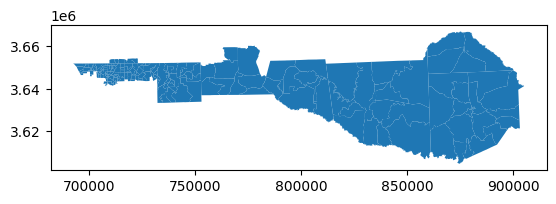

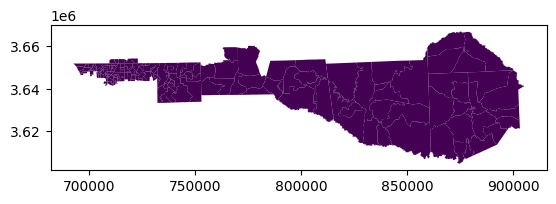

In [47]:

# plot the precincts in the gdf with IDs in this list
i+=1
precincts_idx = list(tx_partition.parts[i])
# make this subset of the gdf into a new gdf, then plot it
precincts_subset = load_precincts[load_precincts.index.isin(precincts_idx)]
precincts_subset.plot()
# turn it into a gerrychain partition and plot it
subset_partition = Partition(tx_graph.subgraph(precincts_idx), assignment="CD25",
                             updaters={"population": Tally("TOTPOP20", alias="population")})
subset_partition.plot(geometries=precincts_subset)
contiguous(subset_partition)